<a href="https://colab.research.google.com/github/ratral/hyd4gpv_py/blob/main/Vertical_Equal_Tangent_Parabolic_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import math
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Flow with flow restriction but without fittings

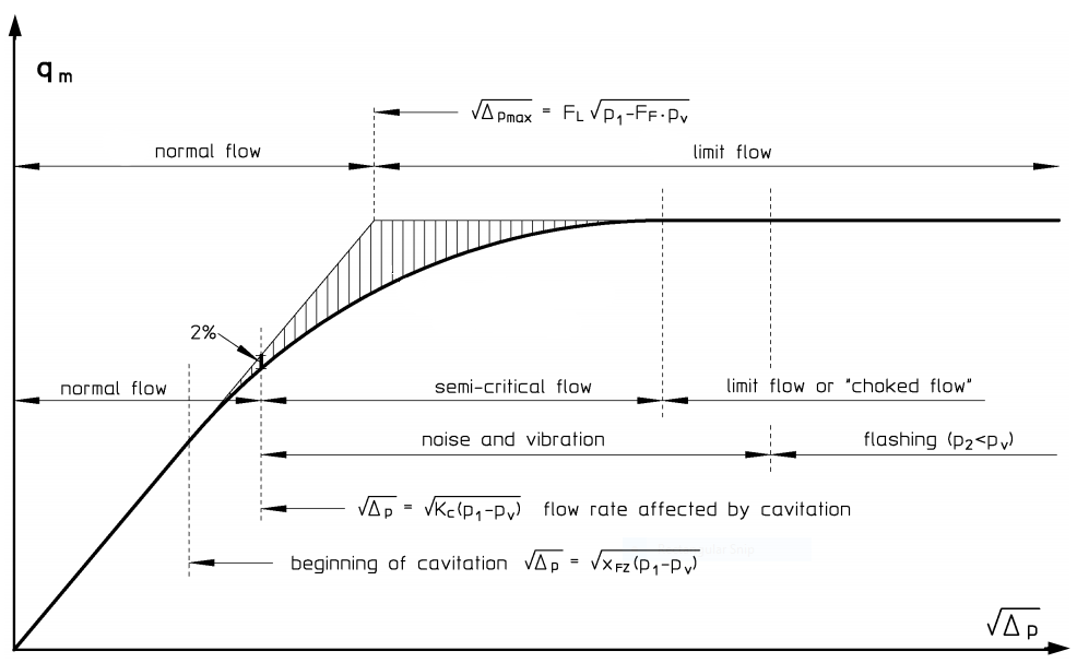

## Elements of Vertical Curve

- $P_1=$ Upstream pressure, constant in bar

- $X_{FZ}=$ The factor for the point of starting the curvature, also known as beginning of cavitation (vertical curve).

- $K_{c}=$ The factor defines the point where noise and vibration or semi-critical flow begins. The flow at this point is $2\%$ less than expected without cavitation. 

- $F_L=$ The factor defines the point of intersection of the tangents, also called begin of the limit flow or o the liquid pressure recovery factor (point of vertical intersection)

- $\sqrt{\Delta{P_{ch}}}=$ Point of tangency, also known as limit flow or "choked flow" (end of vertical curve)

- $𝐿=$ length of parabolic curve, it is the projection of the curve onto a horizontal surface which corresponds to beginning of cavitation ($K_{FZ}$) until the limit flow or "choked flow" ($K_{ch}$).

- $𝑔_1=$ grade (in percent) of back tangent (tangent through $K_{FZ}$).

- $𝑎=$ vertical distance between $K_{FZ}$ and $K_{ch}$

- $𝐻=$ vertical distance between $F_L$ and the curve

---------------------
## Calculations Steps

1. $Temp. = Constant \; (15°C)$

2. $P_1 = constant$; $P_v= constant$ 

3. The value $F_L$ provided by the manufacturer refers to the value when the control valve is fully open.

4. $F_F = 0.96 - 0.28 \cdot \sqrt{\frac{P_v}{221.2}}$

5. $ \sqrt{\Delta{P_{max.}}} = \sqrt{\Delta{P_{F_L}}}= F_L \cdot \sqrt{ {P_1-F_F \cdot P_v}}$

6. $q_{max.} = q_{ch} = K_v \cdot \sqrt{\Delta{P_{max.}}}$

7. $ g_1 = \frac{q_{max.}}{\sqrt{\Delta{P_{max.}}}}$

8. $ \sqrt{\Delta{P_{K_c}}} = F_L \cdot \sqrt{0.80 \cdot (P_1 -P_v)}$ 

9. $q_{K_c} = \left(K_v*\sqrt{\Delta{P_{K_c}}}\right)*0.98$

10. $\sqrt{\Delta{P_{X_{FZ}}}} = F_L \cdot \sqrt{0.60 \cdot (P_1 -P_v)}$ First approximation

11. $q_{X_{FZ}} = K_v*\sqrt{\Delta{P_{X_{FZ}}}} \;$ For the first approximation of $\sqrt{\Delta{P_{X_{FZ}}}}$

12. $L = 2 \cdot \left(\sqrt{\Delta{P_{F_L}}} - \sqrt{\Delta{P_{X_{FZ}}}}\right)$ For the first approximation of $\sqrt{\Delta{P_{X_{FZ}}}}$

13. $ \sqrt{\Delta{P_{ch}}} = \sqrt{\Delta{P_{F_L}}} + L \; \;$ For the first approximation of $\sqrt{\Delta{P_{X_{FZ}}}}$

14. $q_n =K_v \cdot \left( \sqrt{\Delta{P_{X_{FZ}}}} + \frac{\Delta P_n}{4 ⋅(\sqrt{\Delta{P_{F_L}}} - \sqrt{\Delta{P_{X_{FZ}}}})} \right)$ 

In [20]:
#@title Definition of the required functions in Python.

def density(temp_c = 15) -> float:
    """Calculate the density of water in [kg/m³]
    Args:
        temp_c (int, optional): The temperature in Celsius. Defaults to 15°C.
    Returns:
        float: density of water in [kg/m³]
    """
    return  0.14395/(0.0112**(1+(1-(temp_c+273.15)/649.727)**0.05107))


def vapor_pressure(temp_c=15) -> float:
    """Calculate the Vapor pressure of water [bar]
    Args:
        temp_c (int, optional): The temperature in Celsius. Defaults to 15°C.
    Returns:
        float: Vapor pressure of water in bar
    """
    return (0.61121*np.exp((18.678-temp_c/234.5)*(temp_c/(257.14+temp_c))))/100

def ff(temp_c = 15):
    """Calculate the Liquid critical pressure ratio factor
    Args:
        temp_c (int, optional): The temperature in Celsius. Defaults to 15°C.
    Returns:
        float: Liquid critical pressure ratio factor
    """
    return (0.96-0.28*np.sqrt(vapor_pressure(temp_c)/221.2))

def flow_coefficent(p_up, p_down, flow, temp_c=15) -> float:
    """Calculate the Flow Coefficent Kv in m³/h
    Args:
        p_up (float): Upstreampressure in bar
        p_down (float): Downstreampressure in bar
        flow (float): Flow in m³/h
        temp_c (int, optional): The temperature in Celsius. Defaults to 15°C.
    Returns:
        float: Flow Coefficent of the valve Kv in m³/h
    """
    return flow*np.sqrt((density(temp_c)/1000)/(p_up - p_down))

def kv_fun_zeta(diameter, zeta_value) -> float:
    """Return Flow Coefficient Kv in m³/h knowing the Zeta value.
    Args:
        diameter (float): Diameter in meter
        zeta_value (float): Zeta value of the valve at the n position
    Returns:
        float: Flow Coefficent of the valve Kv in m³/h
    """
    return ((diameter*1000)**2)/np.sqrt(626.3*zeta_value)

def delta_pressure_max(p1, fl, temp_c=15):
    """ Maximum Pressure 
    Args:
        p1 (float): Upstreampressure in bar
        fl (float): The pressure recovery coefficient of the valve position
        temp_c (int, optional): The temperature in Celsius. Defaults to 15°C.

    Returns:
        float: Pressure difference where normal flow ends through the control valve.
    """
    return (fl**2)*(p1-ff(temp_c)*vapor_pressure(temp_c))

def flow_max(p1, kv, fl, temp_c=15):
    """  Limit flow or Choked flow
    Args:
        p1 (float): Upstreampressure in bar
        kv (float): Flow Coefficent of the valve Kv in m³/h
        fl (float): The pressure recovery coefficient of the valve position
        temp_c (int, optional):  The temperature in Celsius. Defaults to 15°C.
    Returns:
        float: Limit flow in m³/h
    """
    return kv * np.sqrt(delta_pressure_max(p1, fl, temp_c))

def vertical_curve(sqrt_dp, kv, sqrt_dp_xfz, sqrt_dp_fl):
    """Calculate the transition of the flow during to Choked flow.
    Args:
        dp (float): The square root of the differential pressure to be calculated in bar
        kv (float): Flow Coefficent of the valve Kv in m³/h
        sqrt_dp_xfz (float): The square root of the differential pressure at the start of the incipient cavitation in bars.
        sqrt_dp_fl(float): The square root of the differential pressure at the start of the limit flow in bars.
    Returns:
        float: flow in m³/h
    """
    return kv*(sqrt_dp_xfz + sqrt_dp-sqrt_dp**2/(4*(sqrt_dp_fl- sqrt_dp_xfz)))

# Vectorization of the function vertical_curve2 for use in pandas
v_vertical_curve = np.vectorize(vertical_curve)


In [21]:
#@title Input Data.

valve = "Plunger Valve"
cyl_name = "One-piece body Mobile Flat Cylinder"
w_tempeterure = 15 # Centigrade
dn   = 200 
kv_b = -2.926	
kv_d =  1.527	
kv_e = 80.354	
zvs  =  1.900	
fls  =  0.617	

# Upstream Pressure in bar
p1 = 5


In [22]:
#@title Calculation Data.

# Flow Coefficent Kvs (Full open) in m3/h
kvs = kv_fun_zeta(dn/1000, zvs)

# Calculation maximum point of cavitation
sqrt_dp_fl = np.sqrt(delta_pressure_max(p1, fls))
flow_fl = flow_max(p1, kvs, fls)

# Calculation of constant cavitation point
kc = (0.80*fls**2) 
sqrt_dp_kc = np.sqrt(kc*p1-vapor_pressure())
flow_kc = (kvs*sqrt_dp_kc)*0.98

# Calculation of incipiet cavitation point 
# Xfz = 0.60 Fl^2 # This value muss be extropolated from Kc!!!!
xfz = (0.60*fls**2)
sqrt_dp_xfz = np.sqrt(xfz*p1-vapor_pressure())
flow_xfz = (kvs*sqrt_dp_xfz)

# length of parabolic curve L
curve_length = (sqrt_dp_fl - sqrt_dp_xfz)*2

# shok cavitation point
dp_ch = sqrt_dp_xfz + curve_length
flow_ch = flow_max(p1, kvs, fls)

# Data Frame
# Vertical curve data
data_vc =  np.linspace(start = 0,
                       stop = curve_length,
                       num = 20 )

df_vc = pd.DataFrame(data_vc, columns = ['sqrt_dp'])

df_vc = (
    df_vc
      .assign(
          q = v_vertical_curve(df_vc.sqrt_dp, kvs, sqrt_dp_xfz, sqrt_dp_fl)
      )
)

df_vc = (
    df_vc
      .assign(
          dp_cavitation = df_vc.sqrt_dp + sqrt_dp_xfz
      )
)


In [23]:
#@title Print Values.


print(f'Vapor Pressure: {vapor_pressure():.4} bar')
print(f'Flow Coefficent Kvs: {kvs:,.6} m3/h')

print('\n')

print(f'DP_max.: {delta_pressure_max(p1, fls):,.4} bar')
print(f'Flow_Max.: {flow_max(p1, kvs, fls):,.6} m3/h')

print('\n')

print(f'sqrt_dp_xfz: {sqrt_dp_xfz}')
print(f'flow_xfz: {flow_xfz}')

print('\n')

print(f'dp_ch: {dp_ch}')
print(f'flow_ch: {flow_ch}')

print('\n')
print('\n Data Frame')



df_vc

Vapor Pressure: 0.01705 bar
Flow Coefficent Kvs: 1,159.56 m3/h


DP_max.: 1.897 bar
Flow_Max.: 1,597.17 m3/h


sqrt_dp_xfz: 1.0606673708750298
flow_xfz: 1229.903943278542


dp_ch: 1.6941315032093476
flow_ch: 1597.1727287983397



 Data Frame


,sqrt_dp,q,dp_cavitation
0,0.000000,1229.903943,1.060667
1,0.033340,1267.546450,1.094008
2,0.066680,1303.154227,1.127348
3,0.100021,1336.727274,1.160688
4,0.133361,1368.265591,1.194028
5,0.166701,1397.769178,1.227368
6,0.200041,1425.238034,1.260709
7,0.233382,1450.672161,1.294049
8,0.266722,1474.071557,1.327389
9,0.300062,1495.436223,1.360729


In [24]:
#@title Plot Flow rate diagram

fig = go.Figure([
    go.Scatter(
        name='kv',
        x=[0, sqrt_dp_fl],
        y=[0, flow_fl],
        mode='lines',
        marker=dict(color="blue"),
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='q_max',
        x=[sqrt_dp_fl, sqrt_dp_fl+1],
        y=[flow_fl, flow_fl],
        mode='lines',
        marker=dict(color="blue"),
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='cavitation',
        x= df_vc.dp_cavitation,
        y= df_vc.q,
        mode='lines',
        marker=dict(color="blue"),
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Fl',
        x=[sqrt_dp_fl],
        y=[flow_fl],
        marker=dict(color="crimson", size=6),
        mode='markers',
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Kc',
        x=[sqrt_dp_kc],
        y=[flow_kc],
        marker=dict(color="crimson", size=4),
        mode='markers',
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Xfz',
        x=[sqrt_dp_xfz],
        y=[flow_xfz],
        marker=dict(color="crimson", size=4),
        mode='markers',
        line=dict(width=1),
        showlegend=False
    ),
    go.Scatter(
        name='Chocked',
        x=[dp_ch],
        y=[flow_ch],
        marker=dict(color="crimson", size=4),
        mode='markers',
        line=dict(width=1),
        showlegend=False
    )
])

fig.update_layout(
    xaxis_title='&#8730;(DP)',
    yaxis_title='Flow in (m<sup>3</sup>/h)',
    title='Flow rate diagram of water flowing through a valve (DN-200)<br>plotted versus downstream pressure under constant upstream conditions.',
    width=800, height=600,
    hovermode="x"
)

fig.show()